Khai báo thư viện

In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
np.random.seed(20)
pd.set_option('display.max_rows', None)

Khai báo các hàm sử dụng

In [2]:
class Gaussion_dist(BaseEstimator, TransformerMixin):
    def __init__(self, feature: str, isInt=True) -> None:
        self.feature = feature
        self.isInt = isInt
    def fit(self, X: pd.DataFrame, y=None):
        self.uppper_boundary = X[self.feature].mean() + 3*X[self.feature].std()
        self.lower_boundary = X[self.feature].mean() - 3*X[self.feature].std()
        if self.isInt:
            self.uppper_boundary = int(self.uppper_boundary)
            self.lower_boundary = int(self.lower_boundary)
        return self
    def transform(self, X: pd.DataFrame):
        X_copy = X.copy()
        X_copy.loc[X_copy[self.feature]>=self.uppper_boundary, self.feature] = self.uppper_boundary
        X_copy.loc[X_copy[self.feature]<=self.lower_boundary, self.feature] = self.lower_boundary
        return X_copy

In [3]:
class Skewed_dist(BaseEstimator, TransformerMixin):
    def __init__(self, feature: str, isInt=True) -> None:
        self.feature = feature
        self.isInt = isInt
    def fit(self, X: pd.DataFrame, y=None):
        IQR = X[self.feature].quantile(0.75) - X[self.feature].quantile(0.25)
        self.uppper_bridge = X[self.feature].quantile(0.75)+(IQR*1.5)
        self.lower_bridge = X[self.feature].quantile(0.25)-(IQR*1.5)
        if self.isInt:
            self.uppper_bridge = int(self.uppper_bridge)
            self.lower_bridge = int(self.lower_bridge)
        return self
    def transform(self, X: pd.DataFrame):
        X_copy = X.copy()
        X_copy.loc[X_copy[self.feature]>=self.uppper_bridge, self.feature] = self.uppper_bridge
        X_copy.loc[X_copy[self.feature]<=self.lower_bridge, self.feature] = self.lower_bridge
        return X_copy

In [4]:
def getData(data):
    df_new = pd.get_dummies(data, columns= ['Loại xe', 'Dung tích xe', 'Hãng xe', 'Dòng xe'])
    df_new = df_new.drop(['Tình trạng', 'Xuất xứ', 'Chính sách bảo hành'], axis=1)
    df_new = df_new[(df_new['Giá'] < 50000000) & (df_new['Giá'] > 1000000)]
    X = df_new.drop("Giá", axis=1)
    y = df_new["Giá"]
    return X, y

# Mô hình hóa dữ liệu trên Small Dataset

In [5]:
data=pd.read_csv('clean_data/smalldataset.csv')
data.head()

,Hãng xe,Dòng xe,Năm đăng ký,Số Km đã đi,Tình trạng,Loại xe,Dung tích xe,Xuất xứ,Chính sách bảo hành,Giá
0,Yamaha,Nozza,2014,16000,Đã sử dụng,Tay ga,100 - 175 cc,Đang cập nhật,Bảo hành hãng,12800000
1,Honda,Air Blade,2013,900000,Đã sử dụng,Tay ga,100 - 175 cc,Đang cập nhật,Bảo hành hãng,20500000
2,Honda,Vision,2019,18236,Đã sử dụng,Tay ga,100 - 175 cc,Đang cập nhật,Bảo hành hãng,29600000
3,Honda,@,2007,123456,Đã sử dụng,Xe số,100 - 175 cc,Nhật Bản,Bảo hành hãng,8000000
4,Yamaha,Exciter,2013,2499,Đã sử dụng,Tay côn/Moto,100 - 175 cc,Đang cập nhật,Bảo hành hãng,10800000


In [6]:
X, y = getData(data)

y_test LinearRegression -  (300,)
y_test_predict LinearRegression -  (300,)
0


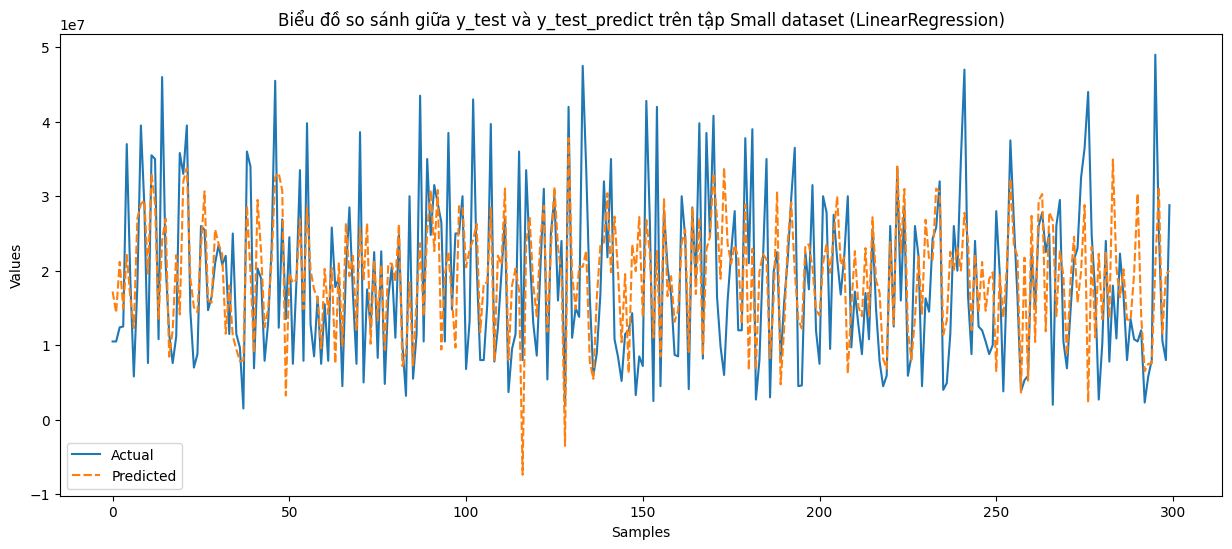

y_test LinearRegression -  (300,)
y_test_predict LinearRegression -  (300,)
1


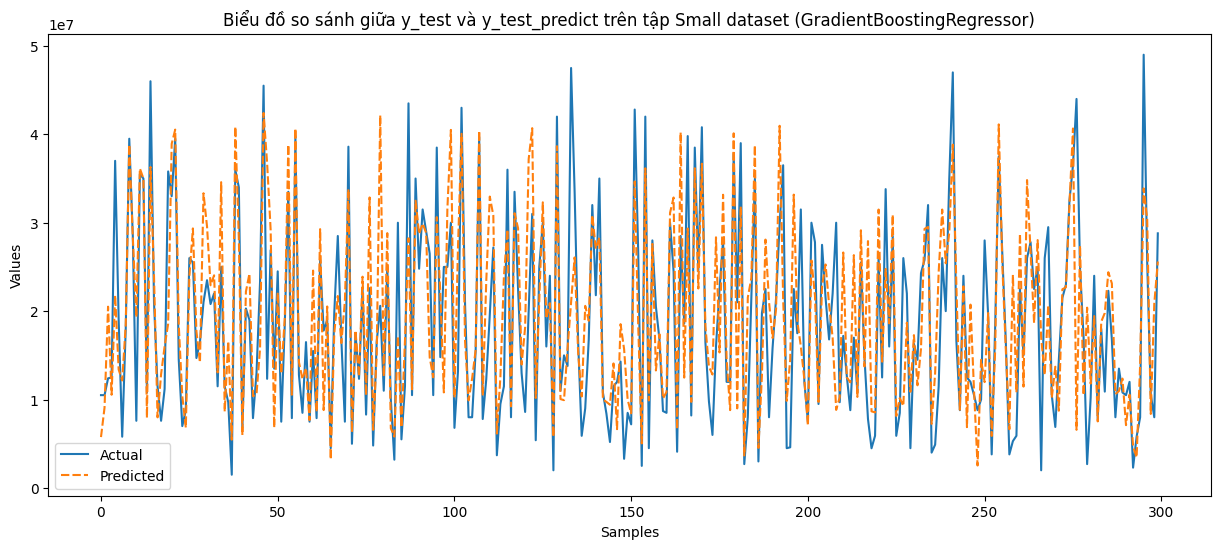

,Model,R2 score on test set (small),R2 score on train set (small),RMSE on test set (small),RMSE on train set (small),MAE on test set (small),MAE on train set (small)
0,Linear Regression,0.318612,0.363914,9.176892e+06,9.448635e+06,7.031959e+06,7.231811e+06
1,Gradient Boosting,0.572646,0.794369,7.267615e+06,5.372241e+06,5.219039e+06,3.655370e+06


In [7]:
function_list = [LinearRegression(), GradientBoostingRegressor(learning_rate=0.02, max_depth=6, n_estimators=1500, subsample=0.5)]
# mean_squared_error
r2_train_list_small = []
r2_test_list_small = []
rmse_train_list_small = []
rmse_test_list_small = []
mae_train_list_small = []
mae_test_list_small = []
i = 0
name = 'LinearRegression'
for function in function_list:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=32)
    pipe = make_pipeline(Gaussion_dist('Năm đăng ký', isInt=True), StandardScaler(), PCA(n_components=30), function)
    pipe.fit(X_train, y_train)
    y_train_predict = pipe.predict(X_train)
    y_test_predict = pipe.predict(X_test)

    # Tạo đối tượng Series từ y_test và y_pred
    y_test_series = pd.Series(y_test, name='Actual')
    y_pred_series = pd.Series(y_test_predict, name='Predicted')

    y_test_series.reset_index(drop=True, inplace=True)
    y_pred_series.reset_index(drop=True, inplace=True)

    print('y_test ' + name + ' - ', np.shape(y_test) )
    print('y_test_predict ' + name + ' - ', np.shape(y_test_predict) )

    # Kết hợp dữ liệu vào một DataFrame
    df_plot = pd.concat([y_test_series, y_pred_series], axis=1)
    plt.figure(figsize=(15, 6))
    # Vẽ đồ thị so sánh
    sns.lineplot(data=df_plot)
    print(i)
    # Đặt tên cho trục x và y
    plt.xlabel('Samples')
    plt.ylabel('Values')
    if i == 1:
        name = 'GradientBoostingRegressor'
    plt.title('Biểu đồ so sánh giữa y_test và y_test_predict trên tập Small dataset (' + name + ')')
    # Hiển thị đồ thị
    plt.show()
    i += 1

    r2_train = r2_score(y_train, y_train_predict)
    r2_test = r2_score(y_test, y_test_predict)
    r2_train_list_small.append(r2_train)
    r2_test_list_small.append(r2_test)
    
    rmse_train = mean_squared_error(y_train, y_train_predict, squared=False)
    rmse_test = mean_squared_error(y_test, y_test_predict, squared=False)   
    rmse_train_list_small.append(rmse_train)
    rmse_test_list_small.append(rmse_test)
    
    mae_train = mean_absolute_error(y_train, y_train_predict)
    mae_test = mean_absolute_error(y_test, y_test_predict)
    mae_train_list_small.append(mae_train)
    mae_test_list_small.append(mae_test)
metric = pd.DataFrame({'Model': ['Linear Regression', 'Gradient Boosting'],
                    'R2 score on test set (small)': r2_test_list_small,
                    'R2 score on train set (small)': r2_train_list_small,
                    'RMSE on test set (small)': rmse_test_list_small,
                    'RMSE on train set (small)': rmse_train_list_small,
                    'MAE on test set (small)': mae_test_list_small,
                    'MAE on train set (small)': mae_train_list_small})
metric

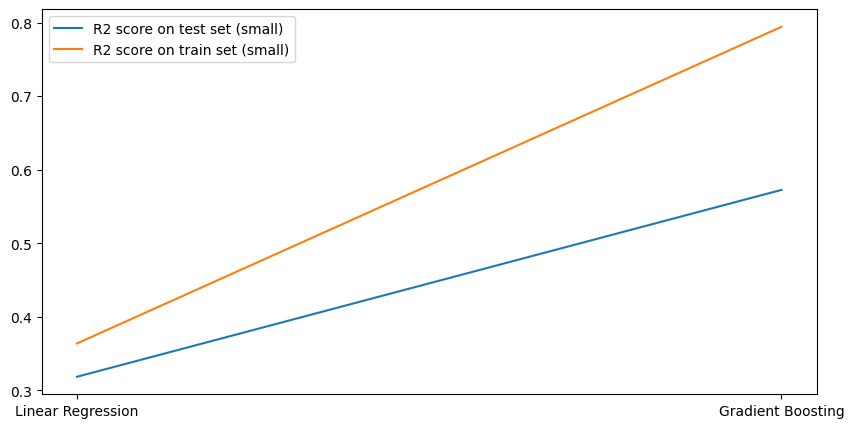

In [8]:
# vẽ biểu đồ so sánh R2 score trên tập train và test của 2 model
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(metric['Model'], metric['R2 score on test set (small)'], label='R2 score on test set (small)')
plt.plot(metric['Model'], metric['R2 score on train set (small)'], label='R2 score on train set (small)')
plt.legend()
plt.show()


# Mô hình hóa dữ liệu trên Big Dataset

In [9]:
data=pd.read_csv('clean_data/bigdataset.csv')
data.head()

,Hãng xe,Dòng xe,Năm đăng ký,Số Km đã đi,Tình trạng,Loại xe,Dung tích xe,Xuất xứ,Chính sách bảo hành,Giá
0,Honda,Wave,1996,20000,Đã sử dụng,Xe số,100 - 175 cc,Đang cập nhật,Bảo hành hãng,1500000.0
1,Piaggio,Liberty,2014,3000,Đã sử dụng,Tay ga,100 - 175 cc,Đang cập nhật,Bảo hành hãng,9500000.0
2,Honda,Cub,1992,70000,Đã sử dụng,Xe số,50 - 100 cc,Đang cập nhật,Bảo hành hãng,12000000.0
3,Yamaha,Exciter,2014,29000,Đã sử dụng,Xe số,100 - 175 cc,Đang cập nhật,Bảo hành hãng,9300000.0
4,Yamaha,Nouvo,2011,55555,Đã sử dụng,Tay ga,50 - 100 cc,Đang cập nhật,Bảo hành hãng,6200000.0


In [10]:
X, y = getData(data)

y_test LinearRegression -  (3002,)
y_test_predict LinearRegression -  (3002,)
0


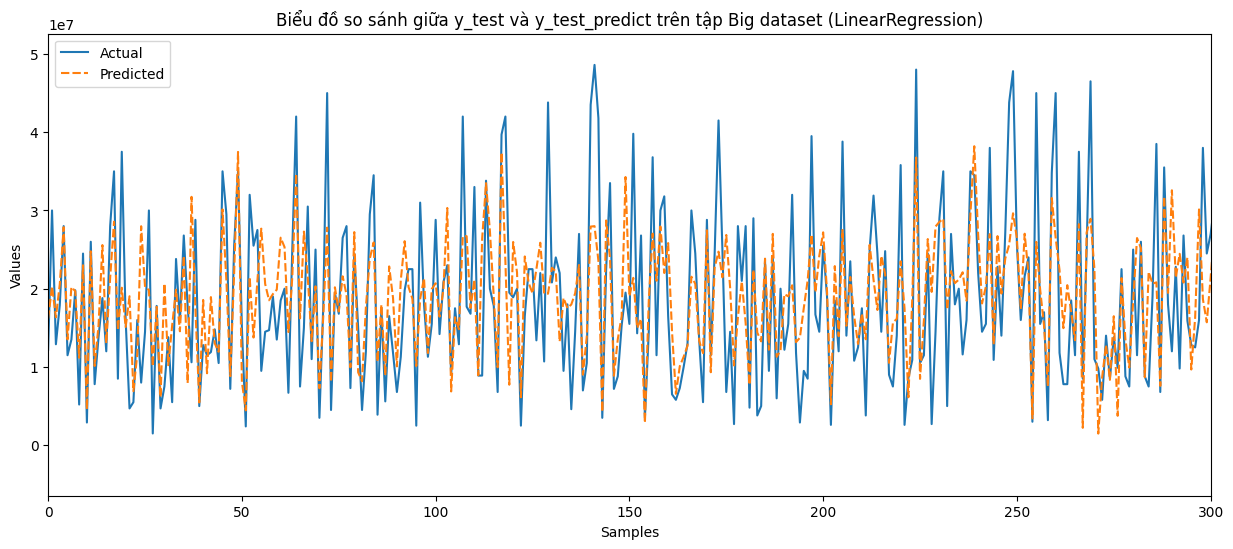

y_test LinearRegression -  (3002,)
y_test_predict LinearRegression -  (3002,)
1


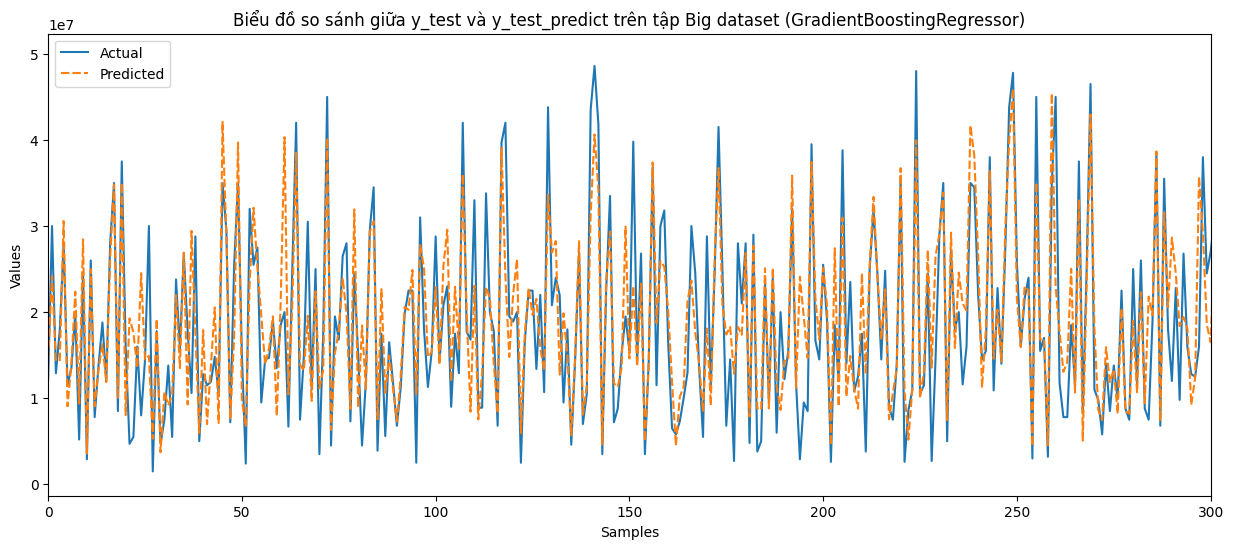

,Model,R2 score on test set (big),R2 score on train set (big),RMSE on test set (big),RMSE on train set (big),MAE on test set (big),MAE on train set (big)
0,Linear Regression,0.392929,0.423567,9.109927e+06,8.832170e+06,6.899412e+06,6.682708e+06
1,Gradient Boosting,0.658277,0.872425,6.834908e+06,4.155053e+06,4.632380e+06,3.076189e+06


In [11]:
function_list = [LinearRegression(), GradientBoostingRegressor(learning_rate=0.02, max_depth=6, n_estimators=1500, subsample=0.5)]
# mean_squared_error
r2_train_list_big = []
r2_test_list_big = []
rmse_train_list_big = []
rmse_test_list_big = []
mae_train_list_big = []
mae_test_list_big = []
i = 0
name = 'LinearRegression'
for function in function_list:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=32)
    pipe = make_pipeline(Skewed_dist('Năm đăng ký', isInt=True), Skewed_dist('Số Km đã đi', isInt=False), PCA(n_components=30) ,function)
    pipe.fit(X_train, y_train)
    y_train_predict = pipe.predict(X_train)
    y_test_predict = pipe.predict(X_test)

    # Tạo đối tượng Series từ y_test và y_pred
    y_test_series = pd.Series(y_test, name='Actual')
    y_pred_series = pd.Series(y_test_predict, name='Predicted')

    y_test_series.reset_index(drop=True, inplace=True)
    y_pred_series.reset_index(drop=True, inplace=True)

    print('y_test ' + name + ' - ', np.shape(y_test) )
    print('y_test_predict ' + name + ' - ', np.shape(y_test_predict) )

    # Kết hợp dữ liệu vào một DataFrame
    df_plot = pd.concat([y_test_series, y_pred_series], axis=1)
    plt.figure(figsize=(15, 6))
    # Vẽ đồ thị so sánh
    sns.lineplot(data=df_plot)
    print(i)
    # Đặt tên cho trục x và y
    plt.xlabel('Samples')
    plt.ylabel('Values')
    if i == 1:
        name = 'GradientBoostingRegressor'
    plt.title('Biểu đồ so sánh giữa y_test và y_test_predict trên tập Big dataset (' + name + ')')
    plt.xlim(0, 300)
    # Hiển thị đồ thị
    plt.show()
    i += 1
    
    r2_train = r2_score(y_train, y_train_predict)
    r2_test = r2_score(y_test, y_test_predict)
    r2_train_list_big.append(r2_train)
    r2_test_list_big.append(r2_test)

    rmse_train = mean_squared_error(y_train, y_train_predict, squared=False)
    rmse_test = mean_squared_error(y_test, y_test_predict, squared=False)   
    rmse_train_list_big.append(rmse_train)
    rmse_test_list_big.append(rmse_test)
    
    mae_train = mean_absolute_error(y_train, y_train_predict)
    mae_test = mean_absolute_error(y_test, y_test_predict)
    mae_train_list_big.append(mae_train)
    mae_test_list_big.append(mae_test)
metric = pd.DataFrame({'Model': ['Linear Regression', 'Gradient Boosting'],
                    'R2 score on test set (big)': r2_test_list_big,
                    'R2 score on train set (big)': r2_train_list_big,
                    'RMSE on test set (big)': rmse_test_list_big,
                    'RMSE on train set (big)': rmse_train_list_big,
                    'MAE on test set (big)': mae_test_list_big,
                    'MAE on train set (big)': mae_train_list_big})
metric

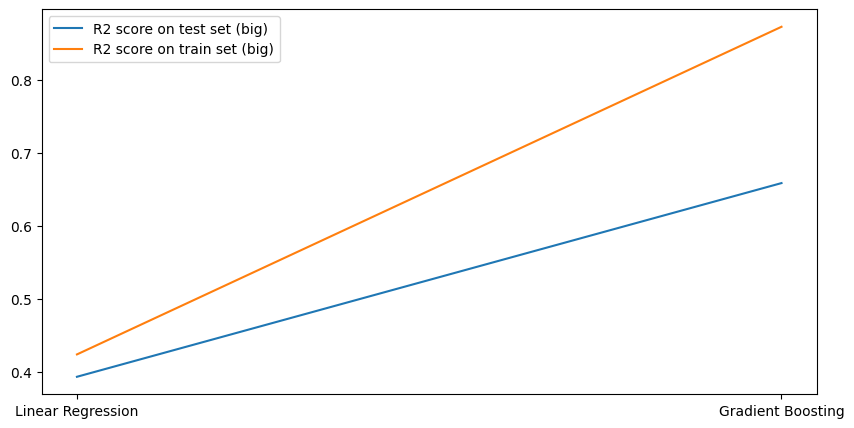

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(metric['Model'], metric['R2 score on test set (big)'], label='R2 score on test set (big)')
plt.plot(metric['Model'], metric['R2 score on train set (big)'], label='R2 score on train set (big)')
plt.legend()
plt.show()